# Stein Variational Gradient Descent

In [1]:
import numpy as np
import time
import pdb
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from utils import *
from distributions import GaussMixture1D, LatentModel
from estimators import run_SVGD, run_MLE
from plotting import *
sns.set()
#plt.style.use('https://github.com/nickteff/EconomistStyle/raw/master/theeconomist.mplstyle')
%load_ext autoreload
%autoreload 2

# Problem 1

Implement SVGD and redo the toy example from Liu and Wang, 2016

In [2]:
# set random seed
np.random.seed(0)
# define mixture of Gaussians 
params = [(-2, 1), (2, 1)]
mixture_wts = [1/3, 2/3]
p_target = GaussMixture1D(params, mixture_wts)
# draw points from initial distribution
x0 = np.random.normal(loc=-10, scale=1.0, size=100)

In [3]:
# run SVGD
x_hist = run_SVGD(x0[:, None], p_target, num_iters=20000, optimizer=Adam, lr=3e-3)

100%|██████████| 20000/20000 [00:16<00:00, 1215.59it/s]


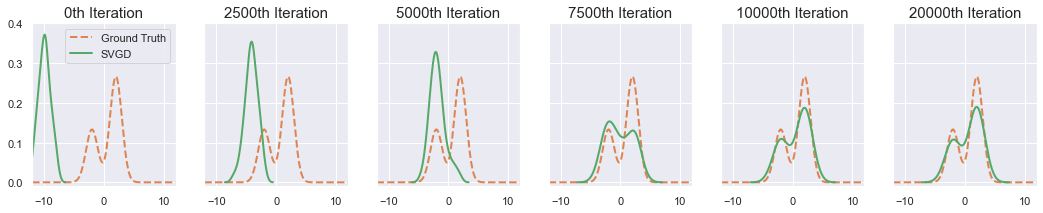

In [4]:
# recreate figure 1 from the paper 
plot_svgd_fig1(x_hist, p_target, iter_list=[0, 2500, 5000, 7500, 10000, 20000])

We can see that while it works(!), it doesn't work quite as well as the example in the paper. It also requires many more iterations to converge. I tried with Adam rather than Adagrad, but it didn't greatly improve sample efficiency as well as different learning rates, but this behavior of close-but-not-quite-perfect convergence persisted. 

As for Figure 2, we first need to run SVGD on the same problem for varying numbers of particles/samples, from 10 to 250. 

In [5]:
particles = []
n_list = np.linspace(10, 250, dtype=int, num=6)
for n in n_list:
    print ("============================")
    print (f"training with {n} particles...")
    start = time.time()
    x0 = np.random.normal(loc=-10, scale=1.0, size=(n, 1))
    x_hist = run_SVGD(x0, p_target, num_iters=15000, optimizer=Adam, lr=3e-3, verbose=False)
    particles.append(x_hist[-1])
    end = time.time()
    print (f"done. training took {np.round((end - start)/60, 2)} minutes.")

training with 10 particles...
done. training took 0.05126555363337199 minutes.
training with 58 particles...
done. training took 0.07378738323847453 minutes.
training with 106 particles...
done. training took 0.24402805169423422 minutes.
training with 154 particles...
done. training took 0.44629775285720824 minutes.
training with 202 particles...
done. training took 0.814700969060262 minutes.
training with 250 particles...
done. training took 1.3298190871874491 minutes.


Now, let's draw samples directly from $p$ to use for Monte Carlo estimation. 

In [8]:
p_samples = [p_target.sample(n) for n in n_list]

Cool. There are three test functions we want expectations of:
$$
h_1(x) = x \\ 
h_2(x) = x^2 \\ 
h_3(x) = \cos(\omega x + b); \quad \omega \sim \mathcal N(0, 1),\ b \sim \textrm{Uniform}([0, 2\pi]).
$$
The first two are pretty simple, in that there are easy closed-form expressions for $\mathbb E_p[h(x)]$ under the mixture distribution, but the last is trickier. The necessary integral is solvable (numerically, in a practical sense), but expensive. The paper draws 20 samples of $(\omega, b)$ and averages across them. This doesn't seem very practical. Instead of directly computing the ground truth expectation for $h_3(x)$, we'll just use form a Monte Carlo estimate (which is unbiased) using 10,000 samples, which should provide a pretty close approximation to ground truth. Let's compute the ground truth values for each test function.

In [6]:
# compute ground truth first and second moments
true_x, true_x2 = 0, 0
for pi, (mu, var) in zip(mixture_wts, params):
    true_x += pi * mu
    true_x2 += pi * (var + mu**2)

# compute "ground truth" for cosine test function
# draw omegas, bs to be used
ncos = 20
omegas = np.random.normal(loc=0, scale=1, size=ncos)
bs = np.random.uniform(low=0, high=2 * np.pi, size=ncos)
# draw samples from mixture distribution
big_sample = p_target.sample(10000)
true_cos = []
for (omega, b) in zip(omegas, bs):
    true_cos.append(np.mean(h3(big_sample, omega=omega, b=b)))
true_cos = np.mean(true_cos)

Ok, now that we have our ground truth estimates, we can compute the Monte Carlo and SVGD estimates. 

In [11]:
# MC estimates 
N = len(n_list)
mc_x, mc_x2, mc_cos = np.zeros(N), np.zeros(N), np.zeros(N)
for i, x in enumerate(p_samples):
    mc_x[i] = np.mean(x)
    mc_x2[i] = np.mean(x**2)
    for (omega, b) in zip(omegas, bs):
        mc_cos[i] += np.mean(h3(x, omega=omega, b=b))
    mc_cos[i] /= ncos
    
    
# SVGD estimates
svgd_x = np.array([np.mean(x) for x in particles])
svgd_x2 = np.array([np.mean(x ** 2) for x in particles])
svgd_cos = np.zeros(N)
for i, x in enumerate(particles):
    for (omega, b) in zip(omegas, bs):
        svgd_cos[i] += np.mean(h3(x, omega=omega, b=b))
    svgd_cos[i] /= ncos

Finally, let's compute the MSEs and plot the results. 

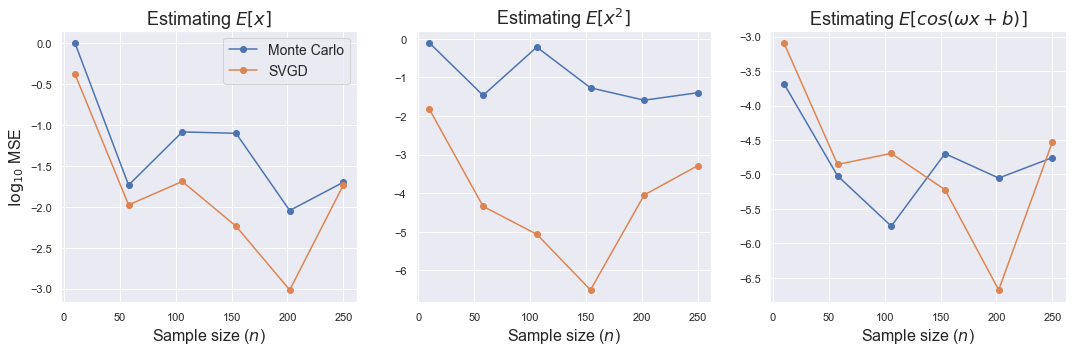

In [14]:
# compute MSEs for MC estimates
mse_mc_x = np.log10([mse(true_x, x) for x in mc_x])
mse_mc_x2 = np.log10([mse(true_x2, x2) for x2 in mc_x2])
mse_mc_cos = np.log10([mse(true_cos, cos) for cos in mc_cos])

# compute MSEs for SVGD estimates
mse_svgd_x = np.log10([mse(true_x, x) for x in svgd_x])
mse_svgd_x2 = np.log10([mse(true_x2, x2) for x2 in svgd_x2])
mse_svgd_cos = np.log10([mse(true_cos, cos) for cos in svgd_cos])

# plot the results
plot_svgd_fig2([mse_mc_x, mse_mc_x2, mse_mc_cos], [mse_svgd_x, mse_svgd_x2, mse_svgd_cos])

Again, not quite as smooth as presented in the paper (repeating the experiment a few times and averaging would likely help), but the gist is there. It's also important to note that the sample sizes in the paper are not linearly spaced from 10 to 250, but without the values being provided I just used ```linspace()``` to get the point across. A potential confound with the cosine test function in this case is that the "ground truth" values used were also from Monte Carlo sampling, albeit a much larger sample size. In the SVGD paper, the authors say that they think the repulsive term in the SVGD update helps get better samples from the distribution, while MC estimates are more biased towards the mode(s) of the distribution. The MC estimate for $h_3$ shares this bias with the "ground truth," possibly explaining its good performance. 

# Problem 2

Consider the following probabilistic model: 
$$
(a,b,c) := \theta \sim Prior(\theta), \\ 
f = a \cdot x^c + b, \\
\epsilon \sim \mathcal N(0, \sigma^2), \\ 
y = f + \epsilon 
$$
Choose a $Prior(\theta)$ and a sensible value for $\sigma^2$; draw a toy data set $\mathcal D$ (20-50 data points) from $y|\theta$ given a sample $\theta\sim Prior(\theta)$; and compute $p(\theta|\mathcal D)$ using SVGD. 

One of the perks of SVGD is that it only requires the score function of the target density, and therefore you don't have to worry about estimating the evidence/normalizer: 
$$
\nabla_\theta \log p(\theta|\mathcal D) = \nabla_\theta [\log p(\mathcal D | \theta) + \log p(\theta) - \log p(\mathcal D)] = \nabla_\theta \log p(\mathcal D | \theta) + \nabla_\theta \log p(\theta) 
$$
In this case, the likelihood is Gaussian, $p(\mathcal D | \theta) = \mathcal N(y; f(\theta), \sigma^2)$, and so by the chain rule the score is 
$$
\nabla_\theta \log p(\mathcal D | \theta) = \frac{y - f(\theta)}{\sigma^2} \nabla_\theta f(\theta),
$$
with $\nabla_\theta f(\theta) = [\frac{\partial f}{\partial a}, \frac{\partial f}{\partial b}, \frac{\partial f}{\partial c}]^\top = [x^c,\ 1,\ x^c\log x]^\top$. 

For the prior $p(\theta)$, we can pick a multivariate Gaussian $\mathcal N(\theta; \mu, \Sigma)$, and in that case the score is 
$$
\nabla_\theta \log p(\theta) = -\Sigma^{-1}(\theta - \mu). 
$$
To perform SVGD, then, we really just need to estimate these quantities and apply the Stein operator as above. 

As a sanity check, we can first use the prior 
$$
p(\theta) = \mathcal N\left(\begin{bmatrix}
a \\ 
b \\ 
c
\end{bmatrix}; 
\begin{bmatrix}
1 \\ 
0 \\ 
0
\end{bmatrix},
\begin{bmatrix}
\tau & 0 & 0 \\
0 & \tau & 0 \\
0 & 0 & \tau
\end{bmatrix}
\right),
$$
where $\tau$ is a small constant. In this case, the prior defines very narrow independent Gaussians such that $(a,b,c) \approx (1, 0, 0)$. In this case, $f \approx a$ $\forall x$, and so $y \sim \mathcal N(a, \sigma^2)$. With a small $\sigma^2$, our posterior $p(\theta | \mathcal D)$ should converge to something pretty close to our prior--something like a delta function in each dimension located at $(1, 0, 0)$. 

In [5]:
# generate data set
seed = 0
np.random.seed(seed)
m, n = 50, 100 # number of points, number of particles to use
prior_mean, prior_cov = np.array([1, 0, 0]), 1e-5*np.eye(3)
X = np.linspace(0.1, 10, num=m)
a, b, c = np.random.multivariate_normal(mean=prior_mean, cov=prior_cov)
f = a * X ** c + b
epsilon = np.random.normal(loc=0, scale=0.1, size=m)
y = f + epsilon

In [6]:
theta0 = np.random.multivariate_normal(mean=0.5 * np.ones(3), cov=2 * np.eye(3), size=n)
md = MessyDistribution(X, y, theta0,
                       var=0.1, seed=0, prior_mean=prior_mean, prior_cov=prior_cov)

svgd = SVGD()
theta_hist = svgd.run(theta0, md, num_iters=20000)

100%|██████████| 20000/20000 [00:39<00:00, 510.04it/s]


As expected, we end up with what amounts to delta functions in the right places:

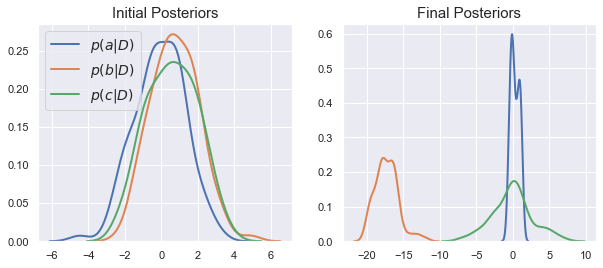

In [11]:
def plot_dists_p2(theta_hist: list, labels: list) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    theta_initial = theta_hist[0]
    theta_final = theta_hist[-1]
    d = theta_final.shape[-1]
    
    # plot initial distributions
    axs[0].set_title("Initial Posteriors", fontsize=15)
    for i, label in enumerate(labels):
        sns.distplot(theta_initial[:, i], hist=False, bins=20, kde=True,
             kde_kws = {'shade': False, 'linewidth': 2},
             label=f"$p({label}|D)$", ax=axs[0], color=f'C{i}', norm_hist=True)
    
    # plot final distributions
    axs[1].set_title("Final Posteriors", fontsize=15)
    for i, label in enumerate(labels):
        sns.distplot(theta_final[:, i], hist=False, bins=20, kde=True,
             kde_kws = {'shade': False, 'linewidth': 2},
             label=None, ax=axs[1], color=f'C{i}', norm_hist=True)
    
    axs[0].legend(fontsize=14)
    plt.show()

plot_dists_p2(theta_hist, ["a", "b", "c"])

Ok, let's use a slightly more complicated prior (but still a Gaussian with diagonal covariance). 

In [8]:
# generate data set
seed = 0
np.random.seed(seed)
m, n = 50, 100 # number of points, number of particles to use
rand_cov = np.random.exponential(size=(3, 3))
rand_cov = rand_cov @ rand_cov.T
prior_mean, prior_cov = np.array([1, 4, 2]), rand_cov
X = np.linspace(0.1, 10, num=m)
a, b, c = np.random.multivariate_normal(mean=prior_mean, cov=prior_cov)
f = a * X ** c + b
epsilon = np.random.normal(loc=0, scale=0.1, size=m)
y = f + epsilon

In [9]:
# run SVGD
theta0 = np.random.multivariate_normal(mean=0.5 * np.ones(3), cov=2 * np.eye(3), size=n)
md = MessyDistribution(X, y, theta0,
                       var=0.1, seed=0, prior_mean=prior_mean, prior_cov=prior_cov)

svgd = SVGD()
theta_hist = svgd.run(theta0, md, num_iters=20000)

100%|██████████| 20000/20000 [00:31<00:00, 625.45it/s]


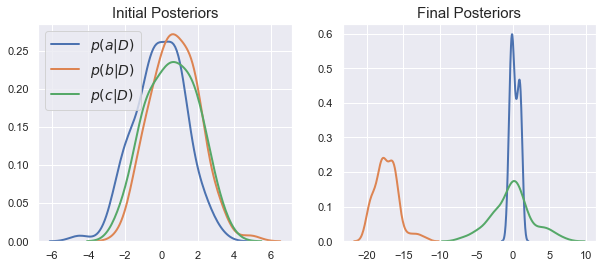

In [26]:
plot_dists_p2(theta_hist, ["$p(a|D)$", "$p(b|D)$", "$p(c|D)$"])

# Problem 3

Also estimate $\theta$ via Maximum Likelihood, yielding $\theta^{(\textrm{MLE})}$. Compare $\theta^{(\textrm{MLE})}$ to $p(\theta|\mathcal D)$ and compare the prediction of $f$ by the above model $p(f|\mathcal D)$ to the prediction of $f$ if one were to fix $\theta =\theta^{(\textrm{MLE})}$ instead ($p(f|\mathcal D, \theta = \theta^{(\textrm{MLE})})$).

In [4]:
theta0 = np.random.multivariate_normal(mean=np.ones(3), cov=2 * np.eye(3))
md = MessyDistribution(X, y, theta0,
                       var=0.1, seed=0, prior_mean=prior_mean, prior_cov=prior_cov)

mle = MLE()
theta_hist_mle = mle.run(theta0[None, :], md, num_iters=20000)

100%|██████████| 20000/20000 [00:00<00:00, 21225.39it/s]


We can see below that the MLE corresponds to the maxima of $(a,b,c)$ if they were independent. However, the prior encodes their mutual dependence through its non-diagonal covariance matrix, so this isn't a good match to the true posterior.  

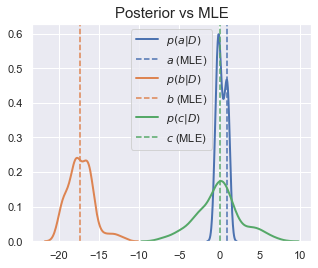

In [22]:
plot_posterior_vs_mle_p3(theta_hist, theta_hist_mle, ["a", "b", "c"])

Let $T_x(\theta) = T_x(a, b, c) = ax^c + b$. The natural route to find $p(f | \mathcal D)$ is 
$$
p(f | \mathcal D) = p(f | x, y) \propto p (y | f) p(f | x, \theta) = p(y | f) p(\theta) |\det(\nabla_f T^{-1}(f))|.
$$
However, $T^{-1}$ is undefined, so instead we can write 
$$
p(f | x, \theta) = \int p(\theta) \delta(f = ax^c + b) d\theta,
$$
where $\delta(\cdot)$ is the Dirac delta function. On the other hand, when $\theta=\theta^{(\textrm{MLE})}:=(a^\ast, b^\ast, c^\ast)$ is fixed, $p(f | x, \theta=\theta^{(\textrm{MLE})} = 1$, so we have 
$$
p(f | \mathcal D, \theta=\theta^{(\textrm{MLE})}) \propto p(y | f)|_{f = f^\ast} = \mathcal N(y; f^\ast, \sigma^2),
$$
where $f^\ast = a^\ast x^{c^\ast} + b^\ast$. 